Num GPUs Available:  1


Copying files: 539 files [00:00, 834.07 files/s]


Down 72 images
Noonan 74 images
Turner 64 images
Williams 120 images
Normal 100 images
(430, 3)
(109, 3)
no of samples in each class
0: 1152
1: 444
2: 1024
3: 720
4: 300


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,997 (56.39 MB)

 Trainable params: 66,309 (259.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.4336 - loss: 2.8220 - val_accuracy: 0.7500 - val_loss: 0.7366
Epoch 2/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.6708 - loss: 0.8202 - val_accuracy: 0.7967 - val_loss: 0.5785
Epoch 3/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.7428 - loss: 0.6438 - val_accuracy: 0.8132 - val_loss: 0.5217
Epoch 4/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.7876 - loss: 0.5325 - val_accuracy: 0.8407 - val_loss: 0.4627
Epoch 5/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8296 - loss: 0.4440 - val_accuracy: 0.8544 - val_loss: 0.4145
Epoch 6/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8620 - loss: 0.3611 - val_accuracy: 0.8764 - val_loss: 0.3553
Epoch 7/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.8807 - loss: 0.3238 - val_accuracy: 0.8846 - val_loss: 0.3589
Epoch 8/15
205/205 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.8883 - loss: 0.2784 - val_ac

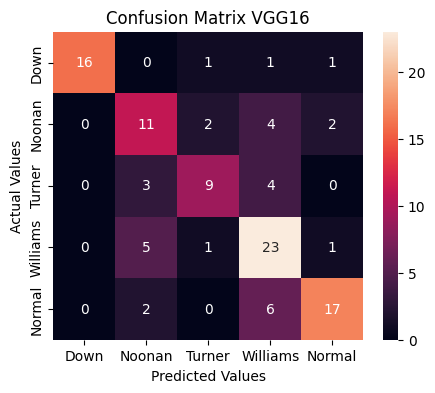

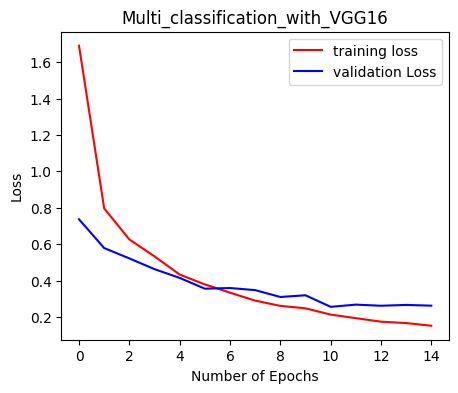

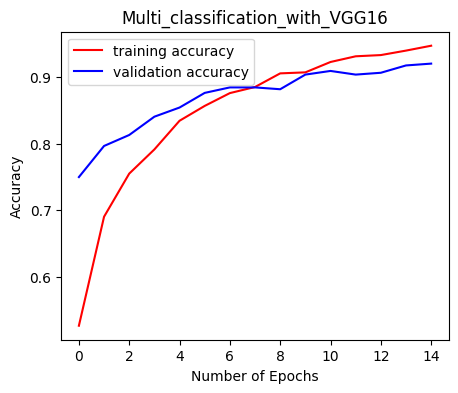

In [11]:
import numpy as np
import copy
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
import cv2
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import seaborn as sns
import skimage.filters as filters
from skimage import exposure
import splitfolders

# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

######## Uploading the dataset ############
input_dir = '/kaggle/input/syndrome-data/NewData'
output_dir = '/kaggle/working/Multi_Input'

# Delete input folder if it exists
if os.path.isdir(output_dir):
    shutil.rmtree(output_dir)

# Create input folder
os.mkdir(output_dir)

# Validate input directory and check for class subfolders
if not os.path.exists(input_dir):
    raise ValueError(f"Input directory {input_dir} does not exist.")
CATEGORIES = ['Down', 'Noonan', 'Turner', 'Williams', 'Normal']
has_classes = all(os.path.exists(os.path.join(input_dir, category)) for category in CATEGORIES)
if not has_classes:
    raise ValueError(f"Input directory {input_dir} does not contain all expected class subfolders: {CATEGORIES}")

# Split dataset
splitfolders.ratio(input_dir, output=output_dir, seed=1337, ratio=(0.8, 0.2))

WIDTH = 224  # Updated to match VGG16 input
HEIGHT = 224
DEPTH = 3  # RGB
INPUT_SHAPE = (WIDTH, HEIGHT, DEPTH)
data_dir = output_dir
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'val')

#### Define class names
CATEGORIES = ['Down', 'Noonan', 'Turner', 'Williams', 'Normal']

##### Calculating the number of images in each category in training data
for category in CATEGORIES:
    print('{} {} images'.format(category, len(os.listdir(os.path.join(train_dir, category)))))

###### Read training data
train = []
for category_id, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(train_dir, category)):
        train.append(['train/{}/{}'.format(category, file), category_id, category])
train = pd.DataFrame(train, columns=['file', 'category_id', 'category'])
print(train.shape)

###### Read testing data
test = []
for category_id, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(test_dir, category)):
        test.append(['val/{}/{}'.format(category, file), category_id, category])
test = pd.DataFrame(test, columns=['file', 'category_id', 'category'])
print(test.shape)

####### Read and segment images
def segment_and_read_img(filepath):
    img = cv2.imread(data_dir + '/' + filepath)
    # Convert to grayscale for segmentation
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Apply thresholding for segmentation
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
        img = img[y:y+h, x:x+w]
    # Resize to 224x224
    img = cv2.resize(img, (WIDTH, HEIGHT))
    return img

traindata = []
for filepath in train.file:
    image = segment_and_read_img(filepath)
    traindata.append(image)

testdata = []
for filepath in test.file:
    image = segment_and_read_img(filepath)
    testdata.append(image)

traindata = np.array(traindata).reshape(len(traindata), WIDTH, HEIGHT, DEPTH)
y_train = to_categorical(train.category_id)

testdata = np.array(testdata).reshape(len(testdata), WIDTH, HEIGHT, DEPTH)
y_test = to_categorical(test.category_id)

####### Data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest',
    brightness_range=(0.5, 1.5))

train_aug = []
y_aug = []
c = 0
for g in range(len(traindata)):
    if y_train[g, 0] == 1 or y_train[g, 2] == 1:
        for i in range(15):
            random = datagen.random_transform(traindata[g])
            train_aug.append(np.uint8(random))
            y_aug.append(y_train[g])
    elif y_train[g, 4] == 1:
        for ii in range(2):
            random = datagen.random_transform(traindata[g])
            train_aug.append(np.uint8(random))
            y_aug.append(y_train[g])
    else:
        for j in range(5):
            random = datagen.random_transform(traindata[g])
            train_aug.append(np.uint8(random))
            y_aug.append(y_train[g])

train_img = np.concatenate((traindata, train_aug), axis=0)
train_label = np.concatenate((y_train, y_aug), axis=0)

# Count each class samples
import collections
arr = np.argmax(train_label, axis=1)
elements_count = collections.Counter(arr)
print('no of samples in each class')
for key, value in elements_count.items():
    print(f"{key}: {value}")

#### Split training data to train/validation
x_train, x_valid, Label_train, Label_valid = train_test_split(train_img, train_label, test_size=0.1, random_state=4)

#########################################################################
##########                Model building  VGG16              ############
#########################################################################

# Load the pre-trained VGG16 model from keras.applications
base_model = VGG16(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

# Freeze the layers of the base network
for layer in base_model.layers:
    layer.trainable = False

# Create a new model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

model.summary()

# Learning rate schedule
learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.96
)
optm = Adam(learning_rate=learning_rate_schedule)

model.compile(optimizer=optm, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, Label_train, validation_data=(x_valid, Label_valid), epochs=15, batch_size=16, shuffle=True, callbacks=[early_stop])

##### Predict the test set #######
ts_label = test.category_id
score = model.evaluate(testdata, y_test, verbose=1)
y_prob = model.predict(testdata)
y_classes = y_prob.argmax(axis=-1)
f1_test = f1_score(ts_label, y_classes, average='micro')

print(f'Test loss: {score[0]} / Test accuracy: {score[1]} / fscore: {f1_test}')

target_names = ['Down', 'Noonan', 'Turner', 'Williams', 'Normal']
print(classification_report(ts_label, y_classes, target_names=target_names))

cm = confusion_matrix(ts_label, y_classes)
cm_df = pd.DataFrame(cm,
                     index=['Down', 'Noonan', 'Turner', 'Williams', 'Normal'],
                     columns=['Down', 'Noonan', 'Turner', 'Williams', 'Normal'])
plt.figure(figsize=(5, 4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix VGG16')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

# LOSS PLOT
plt.figure(figsize=(5, 4))
plt.plot(history.history['loss'], 'r', label='training loss')
plt.plot(history.history['val_loss'], 'b', label='validation Loss')
plt.legend()
plt.title('Multi_classification_with_VGG16')
plt.xlabel('Number of Epochs')
plt.ylabel("Loss")
plt.show()

# Accuracy PLOT
plt.figure(figsize=(5, 4))
plt.plot(history.history['accuracy'], 'r', label='training accuracy')
plt.plot(history.history['val_accuracy'], 'b', label='validation accuracy')
plt.legend()
plt.title('Multi_classification_with_VGG16')
plt.xlabel('Number of Epochs')
plt.ylabel("Accuracy")
plt.show()

In [3]:
!pip install split-folders
